In [1]:
import numpy as np
import pylab as pl
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt

%matplotlib inline

### Modelo y muestras aleatorias

In [2]:
def f(x):
    '''
    Returns a sample with instances without noise.
    '''
    y = np.sin(x) * np.exp(-0.05*x) * np.sqrt(x) * np.sin(0.2*x)
    return (y)

def sample(x, f, noise):
    '''
    Returns a sample with 'size' instances.
    '''
    mn = np.min(f(x))
    mx = np.max(f(x))
    y = f(x) + pl.randn(x.size)*noise*(mx-mn)
    return (y)

------

### Parametros del experimento:

+ tamaño de la muestra
+ cantidad de muestras
+ factor de ruido
+ máximo orden de los polinomios
+ rango de los valores de X
+ cantidad de puntos para graficar las curvas

In [284]:
n_samples = 80
max_degree = 16
n_models = 50
noise = 0.05
n_experiments = 100
xmin = 0
xmax = 10
n_show = 1000

---------------

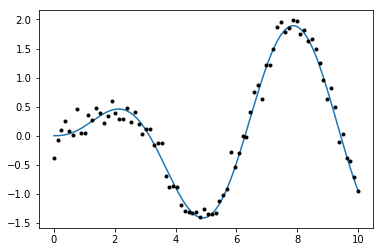

In [285]:
x = np.linspace(xmin, xmax, n_show)
y = f(x)
pl.plot(x, y)

xs = np.linspace(xmin, xmax, n_samples)
ys = sample(xs, f, noise)
pl.plot(xs, ys, 'k.')

### Ajuste de modelos anidados

/home/marce/TeachJob/Astrometria/pyramid/lib/python2.7/site-packages/ipykernel_launcher.py:4: RankWarning: The fit may be poorly conditioned
  after removing the cwd from sys.path.


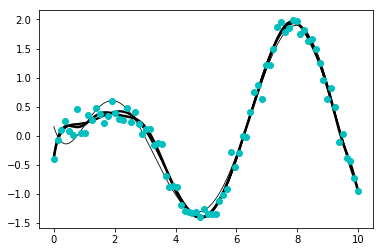

In [286]:
orders = [6,8,10,12, 20]

for i in orders:
    coefs = poly.polyfit(xs, ys, i)
    p_y = poly.polyval(x, coefs)
    lwd = 0.05 + float(i)/16*2
    pl.plot(x, p_y, 'k',lw=lwd)
pl.plot(xs, ys, "co")

Veamos el error que se comete al realizar cada ajuste.  Para eso calculamos en error cuadrático medio:

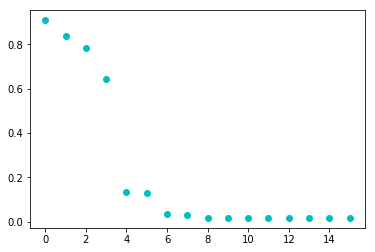

In [287]:
err = []
for i in range(max_degree):
    coefs = poly.polyfit(xs, ys, i)
    p_y = poly.polyval(xs, coefs)
    
    err.append(((ys - p_y)**2).mean())    

pl.plot(range(max_degree), err, "co")

### Promedio de ajustes para varias muestras

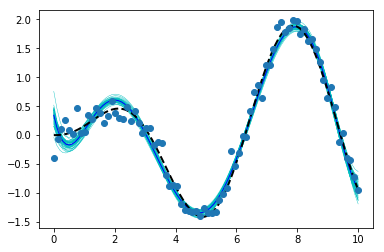

In [288]:
degree = 6

avg_y = np.zeros(100)

xd = np.linspace(0, xmax, 100)
xs = np.linspace(0, xmax, n_samples)

for i in xrange(n_models):
    yss = sample(xs, f, noise)
    
    coefs = poly.polyfit(xs, yss, degree)
    p_y = poly.polyval(xd, coefs)

    avg_y = avg_y + p_y
    p_y = poly.polyval(xd, coefs)
    pl.plot(xd, p_y, 'c-', lw=0.4)
    
avg_y = avg_y / n_models
pl.plot(xd, avg_y, '-b',lw=1.)
pl.plot(xd, f(xd), 'k--', lw=2)
pl.plot(xs, ys, 'o')

### Sesgo y varianza teóricos
Vamos a hacer una estimacion MonteCarlo de la varianza y del sesgo.  Para ello necesitamos saber el modelo verdadero.  Esta no es una situación realista, pero la vamos a usar para entender qué pasa...

In [289]:
from numpy.linalg import norm

xs = np.linspace(0, xmax, n_samples)
yt = f(xs)

var_vals =[]
bias_vals = []
error_vals = []

In [290]:
for degree in xrange(1, max_degree):
    
    avg_y = np.zeros(n_samples)
    models = []
    for i in xrange(n_models):
        
        ys = sample(xs, f, noise)
        
        coefs = poly.polyfit(xs, ys, degree)
        p_y = poly.polyval(xs, coefs)

        avg_y = avg_y + p_y
        models.append(p_y)
        
    avg_y = avg_y / n_models
    bias_2 = norm(avg_y - yt)/ys.size
    bias_vals.append(bias_2)
    variance = 0
    for p_y in models:
        variance += norm(avg_y - p_y)
    variance /= ys.size * n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)

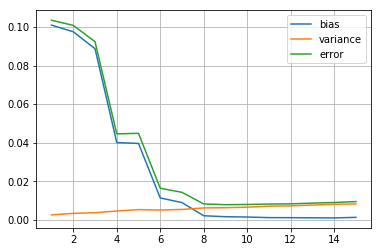

In [291]:
pl.plot(range(1, max_degree), bias_vals, label='bias')
pl.plot(range(1, max_degree), var_vals, label='variance')
pl.plot(range(1, max_degree), error_vals, label='error')
pl.grid()
pl.legend()

### Validación cruzada

En la vida real no tenemos la función, la idea es que tenemos una muestra, de la cual separamos dos submuestras, una de entrenamiento y una de validación.

In [292]:
train_factor = 0.5
n_train = np.int(n_samples*train_factor)

# simulamos una muestra:
x_all = xs #np.linspace(0, xmax, n_samples)
y_all = ys #sample(x_all, f, noise)

# muestras de entrenamiento y validacion:
import random

ids = random.sample(range(n_samples), n_train)

x_train = [x_all[k] for k in range(len(x_all)) if k in ids]
y_train = [y_all[k] for k in range(len(x_all)) if k in ids]

x_test = [x_all[k] for k in range(len(x_all)) if k not in ids]
y_test = [y_all[k] for k in range(len(x_all)) if k not in ids]

In [293]:
coefs = poly.polyfit(x_train, y_train, 12)
y_model = poly.polyval(xd, coefs)    

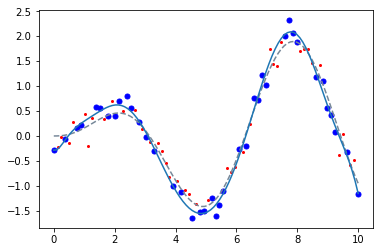

In [294]:
plt.plot(x_train, y_train, ".b", markersize=10)
pl.plot(x_test, y_test, ".r", markersize=4)
pl.plot(xd, f(xd), color='lightslategrey', linestyle='--')
pl.plot(xd, y_model)

In [295]:
test_error_vals = []
train_error_vals = []

for degree in xrange(1, max_degree):
    
    coefs = poly.polyfit(x_train, y_train, degree)
    y_model = poly.polyval(x_train, coefs)
    
    train_error_vals.append( ((y_train - y_model)**2).mean() )
        
    coefs = poly.polyfit(x_test, y_test, degree)
    y_model = poly.polyval(x_test, coefs)   
    
    test_error_vals.append( ((y_test - y_model)**2).mean() )

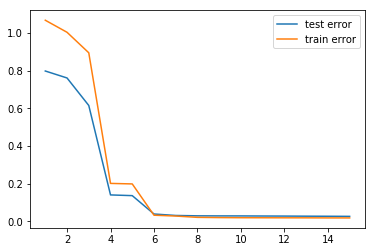

In [296]:
pl.plot(range(1, max_degree), test_error_vals, label='test error')
pl.plot(range(1, max_degree), train_error_vals, label='train error')
pl.legend()

Si hubiéramos tomado las muestras de entrenamiento y de validación de manera diferente, tendríamos seguramente otras curvas....

(0, 3.2206611419562705)

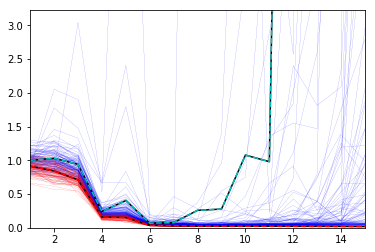

In [298]:
err_train = np.zeros(max_degree-1)
err_test = np.zeros(max_degree-1)
e = 0
#for e in range(n_experiments):
while (e < n_experiments):

    ids = random.sample(range(n_samples), n_train)
    x_train = [x_all[k] for k in range(len(x_all)) if k in ids]
    y_train = [y_all[k] for k in range(len(x_all)) if k in ids]
    x_test = [x_all[k] for k in range(len(x_all)) if k not in ids]
    y_test = [y_all[k] for k in range(len(x_all)) if k not in ids]    
    test_error_vals = []
    train_error_vals = []

    for degree in xrange(1, max_degree):   
              
        coefs = poly.polyfit(x_train, y_train, degree)
        y_model_train = poly.polyval(x_train, coefs)    
        y_model_test = poly.polyval(x_test, coefs)     
        #if (any(abs(y_test-y_model_test)>5)):
        #if(True):
        train_error_vals.append( ((y_train - y_model_train)**2).mean() )        
        test_error_vals.append ( ((y_test  - y_model_test )**2).mean() )                
        
    err_train = err_train + train_error_vals
    err_test = err_test + test_error_vals    
    pl.plot(range(1, max_degree), test_error_vals, 'b',lw=0.1)
    pl.plot(range(1, max_degree), train_error_vals, 'r', lw=0.1)
    e += 1
    
pl.xlim(1,max_degree-1)    
pl.grid()
err_train = err_train / n_experiments
err_test = err_test / n_experiments

pl.plot(range(1, max_degree), err_test, 'k',lw=1.5)
pl.plot(range(1, max_degree), err_test, 'c--',lw=1.5)
pl.plot(range(1, max_degree), err_train, 'k',lw=1.5)
pl.plot(range(1, max_degree), err_train, 'r--',lw=1.5)
pl.grid()
mx = np.max(err_test[1:5])
mn = np.min(err_train[1:5])
pl.ylim(0,  (mx+mn)/2+(mx-mn)*3)